### Imports

In [1]:
# import gevent.monkey
# gevent.monkey.patch_all()

# Webscrap option, import & Other Functions
from lib.config import *

# Set Print Option
desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# constant
HOMEPAGE = 'https://www.imdb.com/'
TITLE_LINK = HOMEPAGE + 'title/tt'
DELAY = random.randint(1, 10)

### EDA

In [3]:
df = pd.read_csv(file_path('Movies.csv'))
print(f'DF Shape:\t{df.shape}\n')
print(f'Types Count:\n{df.dtypes.value_counts()}\n\n')
df_origin = df.copy()
df.head()

DF Shape:	(7131, 8)

Types Count:
object     7
float64    1
dtype: int64




,Movie Hebrew name,Movie name,Extra name,Year,Movie type,Grade,Lead actor\ess,Language
0,הנער,The Kid,NaN,1921.0,Drama,OK,Charles Chaplin,English
1,מטרופוליס,Metropolis,NaN,1927.0,SF,Good,NaN,English
2,סחיטה,Blackmail,NaN,1929.0,Thriller,OK,Alfred Hitchcock,English
3,NaN,The Public Enemy,NaN,1931.0,Drama,Pass,James Cagney,English
4,פריקים,Freaks,NaN,1932.0,Drama,Good,NaN,English


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7131 entries, 0 to 7130
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Movie Hebrew name  4783 non-null   object 
 1   Movie name         7117 non-null   object 
 2   Extra name         610 non-null    object 
 3   Year               7130 non-null   float64
 4   Movie type         7123 non-null   object 
 5   Grade              7128 non-null   object 
 6   Lead actor\ess     4335 non-null   object 
 7   Language           7131 non-null   object 
dtypes: float64(1), object(7)
memory usage: 445.8+ KB


### Nulls

In [5]:
missing_values(df)

,#,%
Extra name,6521,91.4
Lead actor\ess,2796,39.2
Movie Hebrew name,2348,32.9
Movie name,14,0.2
Movie type,8,0.1
Grade,3,0.0
Year,1,0.0


### Duplicates

In [6]:
print(f'Number of Duplicated: \t{df.duplicated().sum()}')

Number of Duplicated: 	10


### Uniques

In [7]:
df['Movie type'].fillna("None", inplace=True)
df['Movie type'] = df['Movie type'].apply(lambda x: x.replace('Documentry', 'Documentary').replace('Animated', 'Animation'))

In [8]:
uni_type = df['Movie type'].unique().tolist()
[(col, df[col].nunique()) for col in df.columns.tolist()]

[('Movie Hebrew name', 4635),
 ('Movie name', 6909),
 ('Extra name', 600),
 ('Year', 93),
 ('Movie type', 15),
 ('Grade', 7),
 ('Lead actor\\ess', 804),
 ('Language', 13)]

In [9]:
for c in df.columns.tolist()[3:]:
    print(f'** {c.upper()} **\n{round(df[c].value_counts(normalize=True)*100,2)}\n')

** YEAR **
2014.0    6.20
2007.0    5.90
2008.0    5.53
2013.0    5.44
2011.0    5.34
          ... 
1929.0    0.01
1938.0    0.01
1934.0    0.01
1921.0    0.01
1943.0    0.01
Name: Year, Length: 93, dtype: float64

** MOVIE TYPE **
Drama          26.64
Comedy         20.68
Thriller       13.62
Action          9.42
SF              7.46
Animation       4.36
Adventure       3.35
Family          2.75
War             2.72
Horror          2.59
Israeli         1.84
Musical         1.72
Documentary     1.67
Western         1.05
None            0.11
Name: Movie type, dtype: float64

** GRADE **
OK           37.70
Less         29.90
Good         20.66
Pass          4.92
Very good     4.18
Bad           1.89
Great         0.74
Name: Grade, dtype: float64

** LEAD ACTOR\ESS **
Bruce Willis           1.29
Nicolas Cage           1.04
Clint Eastwood         0.88
Adam Sandler           0.83
Robert De Niro         0.78
                       ... 
Josh Lucas             0.02
Tsahi Halevi           0.02

#### Initial finding
* data is mostly categorial, except for year and grade (after preprocessing for analysis).
* first I will deal with 10 duplicates
* lots of Nans found on movie naming columns (Movie Hebrew name, Movie name, Extra name) I will combine them.
* Nans on lead actor will be filled from scrapping imdb site
    - function get_links reads movie names list and scrap google search for imdb link.
    - function get_movie_info scrap each link for lead actor name (and more relevent info)
    - notebook will check if info already scraped and read the backup file made on each function.
* Some categories have long tail distribution and with only several abundant values, I will consider only ones from above relevent threshold.

## Preprocessing

### Nulls & Duplicates

In [10]:
df[df.duplicated()]

,Movie Hebrew name,Movie name,Extra name,Year,Movie type,Grade,Lead actor\ess,Language
1556,לצאת נקי,Sexy Beast,NaN,2000.0,Thriller,Less,Ben Kingsley,English
1590,2000.1 החלל מת מצחוק,2001: A Space Travesty,NaN,2000.0,Comedy,OK,Leslie Nielsen,English
1886,ג'קאס - הסרט,Jackass: The Movie,NaN,2002.0,Comedy,OK,NaN,English
2870,קאשבק,Cashback,NaN,2006.0,Comedy,Less,NaN,English
3584,חברים על הכוונת 2,Open Season 2,NaN,2008.0,Animation,Good,NaN,English
3725,NaN,Foreign Exchange,NaN,2008.0,Comedy,Less,NaN,English
3955,אסטרו בוי,Astro Boy,NaN,2009.0,Animation,OK,NaN,English
5795,NaN,The Identical,NaN,2014.0,Musical,Less,Ray Liotta,English
6584,NaN,I Am Wrath,NaN,2016.0,Action,Less,John Travolta,English
6948,NaN,Ride,NaN,2018.0,Thriller,Less,Bella Thorne,English


In [11]:
df.drop_duplicates(inplace=True)

### Combine Movie Name Column

* I will give priority to Extra name values as I find it more informative.

In [12]:
df[['Extra name','Movie name', 'Movie Hebrew name']][~df['Extra name'].isnull()]

,Extra name,Movie name,Movie Hebrew name
5,Sagebrush Trail,An Innocent Man,NaN
7,Triumph of the Will,Triumph des Willens,ניצחון הרצון
56,Sunset Boulevard,Sunset Blvd.,שדרות סנסט
85,The Seven Samurai,Shichinin no Samurai,שבעת הסמוראים
90,Rififi,Du rififi chez les hommes,NaN
...,...,...,...
7065,Operation Brothers,The Red Sea Diving Resort,NaN
7068,Frozen 2,Frozen II,לש את הקרח 2
7080,Rambo Last Blood,Rambo 5,NaN
7086,Serial Bad Weddings 2,Qu'est-ce qu'on a encore fait au bon Dieu?,למה זה מגיע לי 2 ?


In [13]:
df['Name'] = df['Extra name'].fillna(df['Movie name'].fillna(df['Movie Hebrew name'])).str.replace(u'\xa0', u' ') # fillna 4-OM faster than replace

In [14]:
# remove rows with more than 3 nans
df.dropna(thresh=3, inplace=True)

In [15]:
# Year column to datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year

In [16]:
# Grade (target) column encodding
df['Grade'] = df['Grade'].map({'OK':7, 'Good':8, 'Pass':6, 'Less':5, 'Bad':4, 'Very good':9, 'Great':10, np.nan:0})

In [17]:
# Take prominant columns
colms = df.columns.tolist()
cols = colms[-1:] + colms[3:-1]
df = df[cols]
cols

['Name', 'Year', 'Movie type', 'Grade', 'Lead actor\\ess', 'Language']

In [18]:
missing_scores = df['Name'][df['Grade']==0].tolist()
missing_scores

['It Had to Be You', 'Seven Minutes in Heaven']

In [19]:
df_origin = df.copy()

### Fill Missing Actors by Scraping IMDB

In [20]:
missing_values(df)

,#,%
Lead actor\ess,2790,39.2


In [21]:
# Getting Links for movies with missing actors

movies_with_missing_actors = df['Name'][df['Lead actor\\ess'].isnull()].tolist()
filename_txt = 'missing_actors_links.txt'

if not os.path.isfile(file_path(filename_txt)):
    links_for_missing_actors = get_links(movies_with_missing_actors, True)
else:
    links_for_missing_actors = backup_info(filename_txt, df)

File Found...


In [22]:
# Getting missing actors names

filename = 'missing_actors_df.json'
if not os.path.isfile(file_path(filename)):
    info_df = requests_movie_data(filename_txt)
else:
    info_df = backup_info(filename, df)

File Found...


In [23]:
info_df.tail(10)

,Name,Links,Lead actor\ess,Score,Type
2696,Someone Great,https://www.imdb.com/title/tt8075260,Gina Rodriguez,6.2,Comedy
2697,Tall Girl,https://www.imdb.com/title/tt9252508,Ava Michelle,5.2,Comedy
2698,Good Boys,https://www.imdb.com/title/tt6977338,Jacob Tremblay,6.7,Adventure
2699,Jexi,https://www.imdb.com/title/tt9354944,Adam Devine,6.0,Comedy
2700,I Used to Go Here,https://www.imdb.com/title/tt10887902,Gillian Jacobs,5.6,Comedy
2701,Onward,https://www.imdb.com/title/tt7146812,Tom Holland,7.4,Animation
2702,Tenet,https://www.imdb.com/title/tt6723592,John David Washington,7.4,Action
2703,Pieces of a Woman,https://www.imdb.com/title/tt11161474,Vanessa Kirby,7.0,Drama
2704,Rose Island,https://www.imdb.com/title/tt10287954,Elio Germano,7.0,Adventure
2705,Song of the South,https://www.imdb.com/title/tt0038969,Ruth Warrick,7.0,Animation


In [24]:
info_df["Score"] = np.array(info_df["Score"].round())

In [25]:
# Check if created differences between two sets of missing actors lists
first_set = set(df['Name'])
sec_set = set(info_df['Name'])
print(f'Differences between two lists: {sec_set - first_set}')
print(f'Number of Movies to scrap:\t{len(first_set & sec_set)}')

Differences between two lists: set()
Number of Movies to scrap:	2706


In [26]:
df['Links'] = info_df['Links'].apply(lambda x: x.replace(TITLE_LINK, ''))
df['Lead actor\\ess']= df['Lead actor\\ess'].fillna(df['Name'].map(dict(zip(info_df['Name'], info_df['Lead actor\\ess']))))

In [27]:
missing_values(df)

,#,%
Links,4417,62.0
Lead actor\ess,38,0.5


In [28]:
# Fill in the blanks
miss_val_ind = df.iloc[df[df['Lead actor\\ess'].isnull()].index]
print(len(miss_val_ind))
file_found = os.path.isfile(file_path('dataframe_q1.json'))
if len(miss_val_ind) > 0 and not file_found:
    missing_actors = get_movie_data(miss_val_ind, 'actor')
else:
    missing_actors = backup_info('dataframe_q1.json')

38
File Found...


In [29]:
df['Lead actor\\ess'] = df['Lead actor\\ess'].fillna(df['Name'].map(dict(zip(missing_actors['Name'], missing_actors['Lead actor\\ess']))))

In [30]:
missing_values(df)

,#,%
Links,4417,62.0


### Parsing movie dump file

In [31]:
# Reading file
filename = file_path('movie_dump.txt')
with open(filename) as f:
    txt = f.readlines()
print(f'Example:\n{txt[10]}')

Example:
ed2k://|file|Allegro%20Non%20Troppo%201977%20Heb%20Sub.avi|721428480|D09A26DFC84BBE18C08ECE77E67CC52C|/



- I Create tokens for regex sub and tokens for split, as some tokens are found after the movie name and some in between. 
- I treat the string in certain order for maximum cleanising.

In [32]:
# initial pattern to filter only relevent lines and mid string.
pattern = r'(?<=ed2k:\/\/\|file\|)(.*)(?=.avi|.m)' 
# Create token that found occasionally to sub with ''. 
tokens_sub = r'\([^()]*\)|\[[^()]*\]|\{[^()]*\]|%\w.|\W{1}|\s{1,}|_{2,}|([720|1080]{3,}[p|P|H])'
# Add special cases tokens found after targeted movie name.
tokens_split = '_{3,}|heb|sub|[DdvhBbr]rip|cd\d|xvid|web|dubbed|french|dv|sd|vo|x264|ita|bluray|int|english|spanish|wolt|Drama'

In [33]:
new_file = []
for line in txt:
    result = re.findall(pattern, line)
    if result:
        # dealing first with special cases like %20 and tv series with episodes count.
        new_line = re.sub('%20|\.', '_', str(*result))
        new_line = re.split('[s|S]*\d{1,2}[E|e|x]\d{2}', new_line)[0]
        
        # using tokens for sub and split
        new_line = re.sub(tokens_sub, '', new_line, flags=re.IGNORECASE).strip('_')
        new_line = re.split(tokens_split, new_line, flags=re.IGNORECASE)[0].strip('_')
        new_line = re.sub('\s*[HB]{1}$', '', new_line).strip()
        year = re.findall('[20|19]{2}\d{2}', new_line)
        
        # finalizing strings
        new_line = new_line.replace('_', ' ')
        new_file.append(''.join(new_line+'\n'))

In [34]:
movie_dump_names = set(new_file)
print(*movie_dump_names, sep='\n')

Fauda

Kolirin Eran La banda nos vis

The Lion King ORIG

A Good Man 2014

1984Amadeus

Superman Batman Apocalypse 2010 D XRUBY

Criminal Activities 2015

ice age 2

Dildo  Siswet  Ik

Red Heat 1988

7 Days in Entebbe 2018

2  The Addams Family Values

Kicking Out Shoshana

Alice In Wonderland 1951

The Wife 2018

Foxtrot La Danza Del Destino

Margar

The Land Of Steady Habits

Bordering on Bad Behavior 2014

Death Wish 1974

james bond 1985 A View To A Kill

Space Chimps

Ugly Girls xxx

Charles Bronson Alain Delon  Red Sun

Cloud Atlas  

un appuntamento per la sposa 2016

1949

Foxtrot  La danza del destino  2018  108 min  AC3

James Bond 1983 Never Say Never Again

007 The Man With The Golden Gun

The Death of Stalin 2017

Hour Of The Pig Aka The A

The Shawshank Redemption 1994

Child Of The Terraces 1990

the kissing booth 2018

Clone Star Wars The Wars

The Errand Boy  Jerry Lewis

4 A New Hope 4 1977

Stalingrad 2014

Teheran

The Magic Sword Quest for Camelot

The Pink Panther

### Backup to file and add missing info

In [35]:
filename_dump_links = 'dumpfile_links.txt'
file_found = os.path.isfile(file_path(filename_dump_links))
if not file_found:
    parsed_names_links = get_links(movie_dump_names, filename_dump_links, True)
else:
    parsed_names_links = backup_info(filename_dump_links, movie_dump_names)

File Found...


In [36]:
filename_dump_df = 'dumpfile_links_df.json'
if not os.path.isfile(file_path(filename_dump_df)):
    dump_df = get_movie_data(filename_dump_links)
    dump_df = backup_info(filename_dump_df, pd.DataFrame(dump_df), True)
else:
    dump_df = backup_info(filename_dump_df, df)

File Found...


### Some preprocessing: rounding score, drop dups, fill missing names

In [37]:
dump_df['Name'] = dump_df['Name'].apply(lambda x: x.strip('\n'))

ind = np.where(dump_df['Title'].str.contains('VIDEOS'))[0]
dump_df.at[ind, 'Title'] = dump_df['Name'][ind]

ind = np.where(dump_df['Title']=='')[0]
dump_df.at[ind, 'Title'] = dump_df['Name'][ind]

dump_df.drop('Name', axis=1, inplace=True)

In [38]:
dump_df['Type'].fillna('Other', inplace=True)
dump_df['Type'] = dump_df['Type'].str.strip()

In [39]:
dump_df['Lead actor\ess'].fillna('Other', inplace=True)

In [40]:
dump_df['Score'].fillna(np.mean(dump_df['Score']), inplace=True)
dump_df["Score"] = np.array(dump_df["Score"].apply(lambda x: round(x)))

In [41]:
dump_df["Links"] = dump_df["Links"].apply(lambda x: x.replace(TITLE_LINK, ''))

In [42]:
dump_df['Year'] = pd.to_datetime(dump_df['Year'], format='%Y').dt.year

In [43]:
dump_df.rename(columns={'Title':'Name', 'Score':'Grade', 'Type':'Movie type'}, inplace=True)

In [44]:
DF = df.append(dump_df)

In [45]:
print(f"Number of Duplicates:\t{len(DF[DF.duplicated(['Name','Links'])])}")

Number of Duplicates:	81


In [46]:
DF.drop_duplicates(inplace=True)

- I Started the task with the original df and preprocess its info and cleaned whats was necessary (check under Q1).
- I filled NaN values by scraping imdb and google search (in order to have movie info and imdb movie link, respectively).
- For the dump file, I used regex search and split to return movie list. (check parsing section for more info)
- I prefered to keep some sort of generlize solution for new cases of dump files, not w\o a cost.
- Since generalize parsing left some dirty strings, I used google self parsing by scrap google search that will further clean string names and returns movie imdb link (a unique movie id that works perfectly while combining all info to original df).
- Finilized combined df with left over preprocessing and remove duplicate values from dfs.
- Some nulls were left in purpose. (columns are non relevant for further work)

In [47]:
missing_values(DF)

,#,%
Links,4413,60.4
Language,187,2.6


In [48]:
DF.info(), DF.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7303 entries, 0 to 197
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            7303 non-null   object
 1   Year            7303 non-null   int64 
 2   Movie type      7303 non-null   object
 3   Grade           7303 non-null   int64 
 4   Lead actor\ess  7303 non-null   object
 5   Language        7116 non-null   object
 6   Links           2890 non-null   object
dtypes: int64(2), object(5)
memory usage: 456.4+ KB


(None, (7303, 7))

### Data Visualization

In [49]:
cols

['Name', 'Year', 'Movie type', 'Grade', 'Lead actor\\ess', 'Language']

In [50]:
print(f'There are {len(DF[cols[4]].value_counts())} unique lead actors on data set.')

There are 2776 unique lead actors on data set.


In [51]:
# Checking correlation between actor & score
def normalize(array):
    norm = np.linalg.norm(array)
    normal_array = array/norm
    return round(((1-normal_array)*100).mean(), 1)

norm_val = lambda x: normalize(x)
count_val = lambda x: x.count()
count_top_score = lambda x: (x >= 8).sum()
mean_score = lambda x: round(x.mean(), 1)
med_score = lambda x: round(x.median(), 1)

q3_df = pd.DataFrame(DF.groupby('Lead actor\ess')['Grade'].agg([count_val, count_top_score, norm_val, mean_score, med_score]))
q3_df.columns = ('# Movies','# Scores >8', 'Mean Score (norm)', 'Mean', 'Median')
q3_df['Top scores (%)'] = 100*round(q3_df['# Scores >8']/q3_df['# Movies'],1)
q3_df = q3_df.sort_values(['Mean Score (norm)', 'Top scores (%)'], ascending=False).head(20)
q3_df

,# Movies,# Scores >8,Mean Score (norm),Mean,Median,Top scores (%)
Lead actor\ess,,,,,,
Bruce Willis,57,31,87.0,7.4,8.0,50.0
Nicolas Cage,47,21,85.7,7.1,7.0,40.0
Adam Sandler,39,22,84.2,7.5,8.0,60.0
Clint Eastwood,38,21,84.0,7.6,8.0,60.0
Tom Hanks,36,23,83.5,7.8,8.0,60.0
Robert De Niro,34,10,83.2,6.9,7.0,30.0
Matt Damon,33,16,82.9,7.2,7.0,50.0
Nicole Kidman,32,7,82.7,6.4,7.0,20.0
Johnny Depp,31,11,82.3,6.9,7.0,40.0


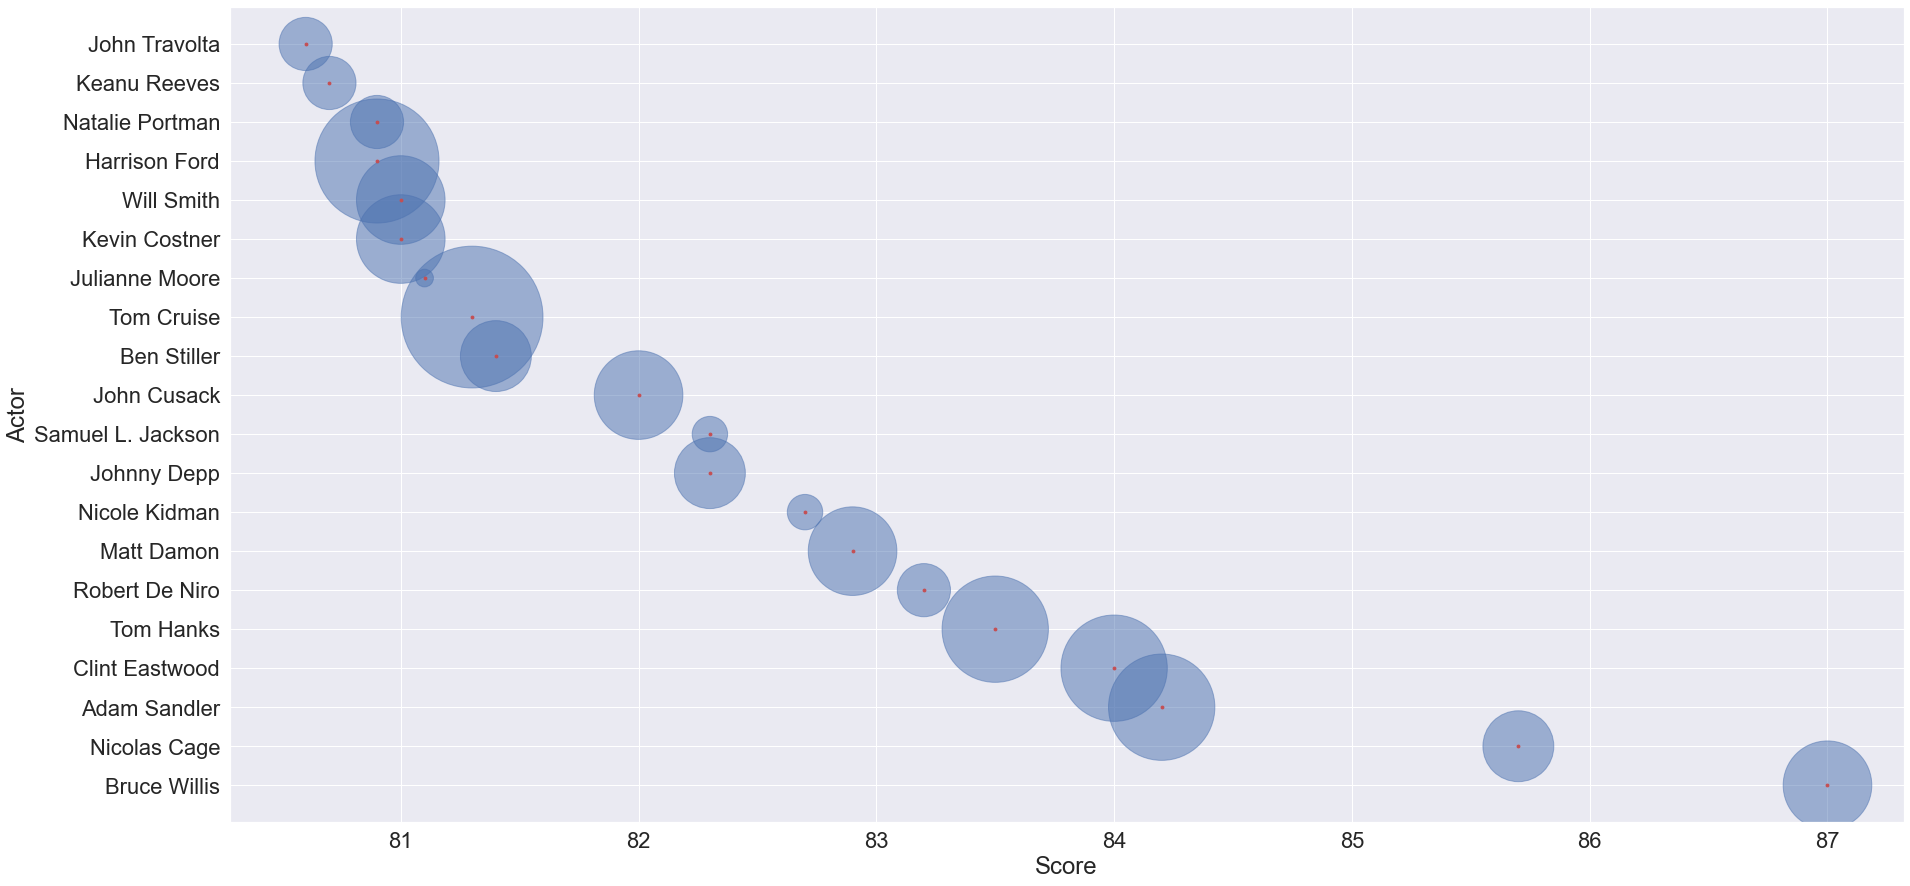

In [52]:
s = np.pi * (q3_df['Top scores (%)'])**2
y = q3_df.index
x = q3_df['Mean Score (norm)']

# plot
sns.set(font_scale=2)
plt.subplots(figsize=(30,15))
plt.axes(xlabel='Score', ylabel='Actor')
plt.scatter(x, y, s, alpha=0.5)
plt.scatter(x, y, 8,'r')

plt.show();

 - Actors like Bruce Willis, Nicolas Cage and Adam Sandler are found at the top of the score table. With ~ 50% of the movies they played in have high score.
 - They are also very popular actors and in demand, they played in much more movies than others, so I normalized scores and added size to each point as the ratio of total movies played : movies played and got high score(>8).
 - Cant conclude and note this corralation is enough to cause high scores, One should consider both size and value from correlation plot.

### Grade Distributions

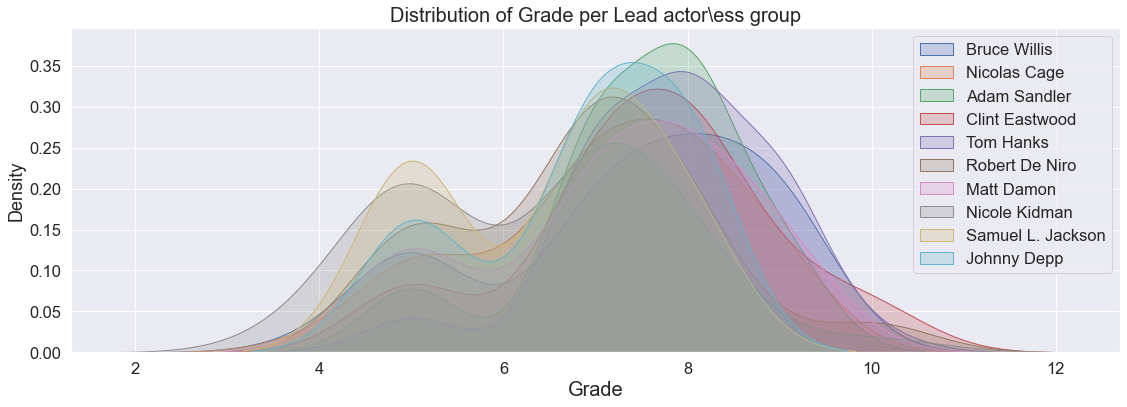

In [57]:
display_group_density_plot(DF, 'Lead actor\\ess', "Grade", figsize=(16,6))

 - Top 10 actors in terms of popularity which participate in more movies than other are plot here.
 - Bruce Willis, Tom Hanks and Clint showing spreaded shoulder in distribution toward higher scores.
 - Samuelle L.J and Nichole Kidman almost balanced their high-low score distribution.

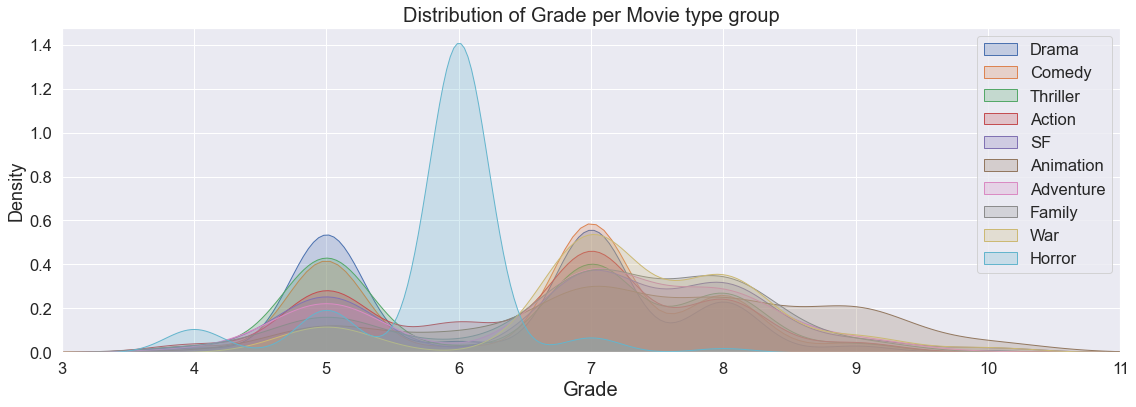

In [59]:
display_group_density_plot(DF, 'Movie type', 'Grade', figsize=(16,6), xlim=(3,11))

    - Strong indication that Horror movie are mediocre at best.
    - Animations have long tail distribution towards higher grades more than any movie type.
    - War, Drama, Comedy in order are next in rank.

##### Some more Cat Counts.

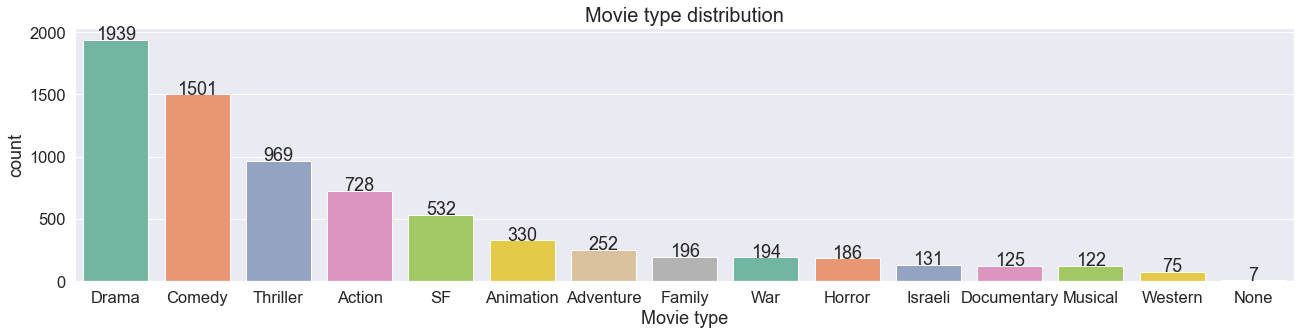

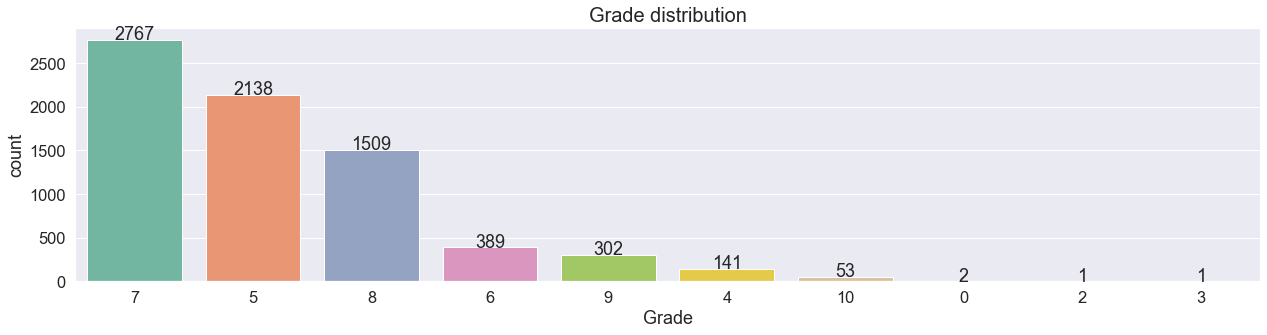

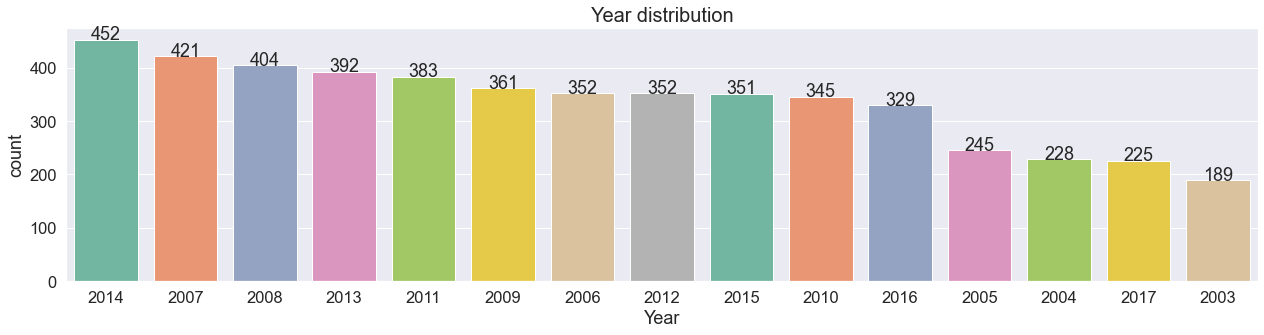

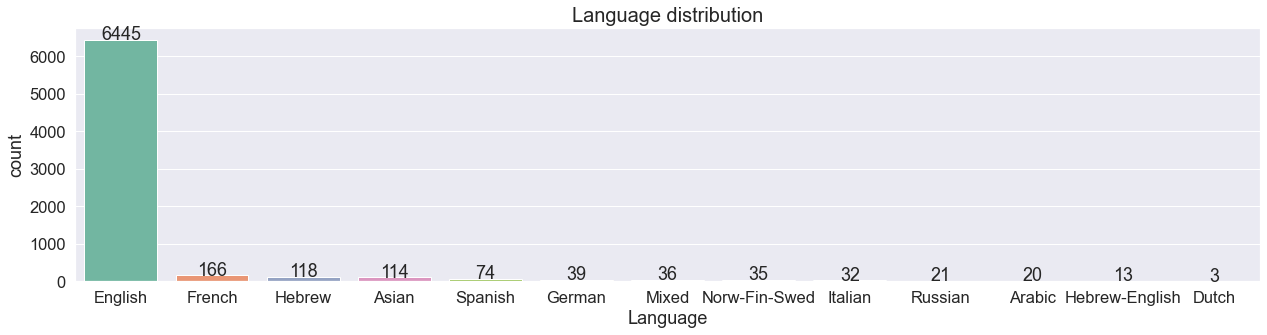

In [55]:
plot_cat_dist(DF, ["Movie type", 'Grade', 'Year', "Language"]) 

### Category plot distributions show us the most abundant values on data set
* Type: Drama and comedy
* Grade: 7 has more 33% of data points after that are 5, 8.
* Year: close to uniform distribution main counts took from 2006-2016
* Lang: English > 90% of data points (should be droped).